In [1]:
### Libraries for Machine Learning
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import glob
import os

import mplcyberpunk

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, accuracy_score
from statsmodels.stats import anova
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [2]:
# Get a list of all CSV files in the folder
csv_files = glob.glob("*.csv")

# Load each CSV file, adding a 'filename' column, and store them in a list
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df["filename"] = os.path.basename(file)  # Add filename column
    dataframes.append(df)

# Concatenate all dataframes into one
har70_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows
print(har70_df.head())


                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2021-03-24 14:42:03.839 -0.999023 -0.063477  0.140625 -0.980469 -0.112061   
1  2021-03-24 14:42:03.859 -0.980225 -0.079346  0.140625 -0.961182 -0.121582   
2  2021-03-24 14:42:03.880 -0.950195 -0.076416  0.140625 -0.949463 -0.080566   
3  2021-03-24 14:42:03.900 -0.954834 -0.059082  0.140381 -0.957520 -0.046143   
4  2021-03-24 14:42:03.920 -0.972412 -0.042969  0.142822 -0.977051 -0.023682   

    thigh_z  label filename  
0 -0.048096      6  501.csv  
1 -0.051758      6  501.csv  
2 -0.067139      6  501.csv  
3 -0.050781      6  501.csv  
4 -0.026611      6  501.csv  


In [3]:
har70_df.dtypes

timestamp     object
back_x       float64
back_y       float64
back_z       float64
thigh_x      float64
thigh_y      float64
thigh_z      float64
label          int64
filename      object
dtype: object

In [4]:
#make a copy of the raw data so that we can go back and refer to it later
har70 = har70_df.copy()

In [5]:
har70['timestamp']=pd.to_datetime(har70['timestamp'])

In [6]:
har70.describe()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,2259597,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06,2.259597e+06
mean,2021-05-02 09:36:36.616267264,-8.699344e-01,-3.316850e-02,2.342491e-02,-6.796213e-01,2.774742e-03,-3.841220e-01,3.911567e+00
min,2021-03-24 14:42:03.839000,-4.333252e+00,-2.031006e+00,-2.204834e+00,-7.942139e+00,-5.142578e+00,-7.593750e+00,1.000000e+00
25%,2021-04-13 15:03:39.180000,-9.929200e-01,-1.096190e-01,-2.751460e-01,-9.873050e-01,-1.166990e-01,-9.860840e-01,1.000000e+00
50%,2021-05-07 08:32:19.208999936,-9.392090e-01,-2.172900e-02,-1.125490e-01,-9.357910e-01,-1.562500e-02,-1.877440e-01,3.000000e+00
75%,2021-05-27 09:33:48.659000064,-8.281250e-01,5.078100e-02,3.125000e-01,-7.055700e-02,1.123050e-01,-4.150000e-03,7.000000e+00
max,2021-06-11 11:13:14.178000,3.630370e-01,1.576660e+00,1.179199e+00,3.395264e+00,5.725098e+00,3.953369e+00,8.000000e+00
std,NaN,2.689122e-01,1.513270e-01,4.327357e-01,5.517539e-01,2.736956e-01,5.127760e-01,2.902911e+00


<Axes: >

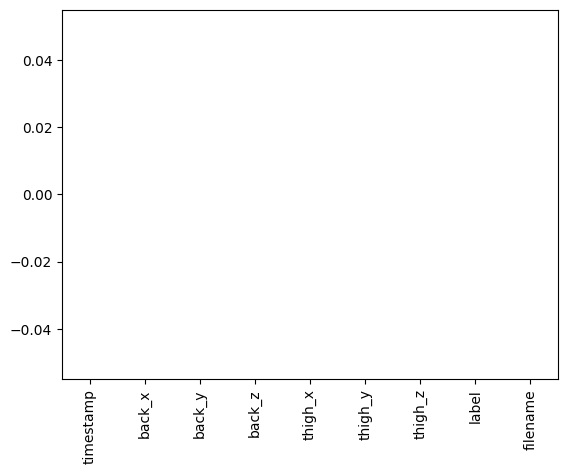

In [7]:
har70.isna().sum().plot.bar()

<Axes: xlabel='timestamp'>

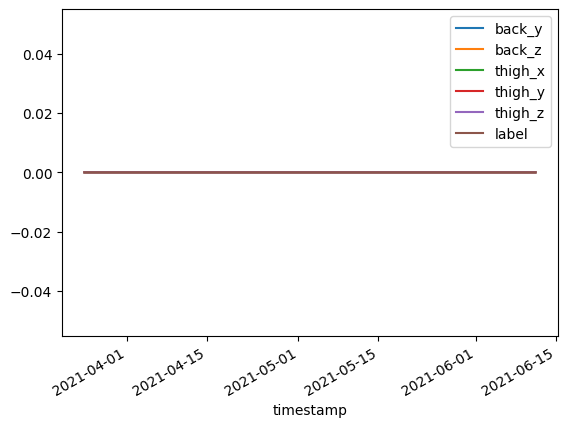

In [8]:
har70_na = har70.drop('timestamp', axis = 1).isna().groupby(har70.timestamp, sort = False).sum().reset_index()
har70_na.plot(x='timestamp', y=har70_na.columns[2:-1])


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

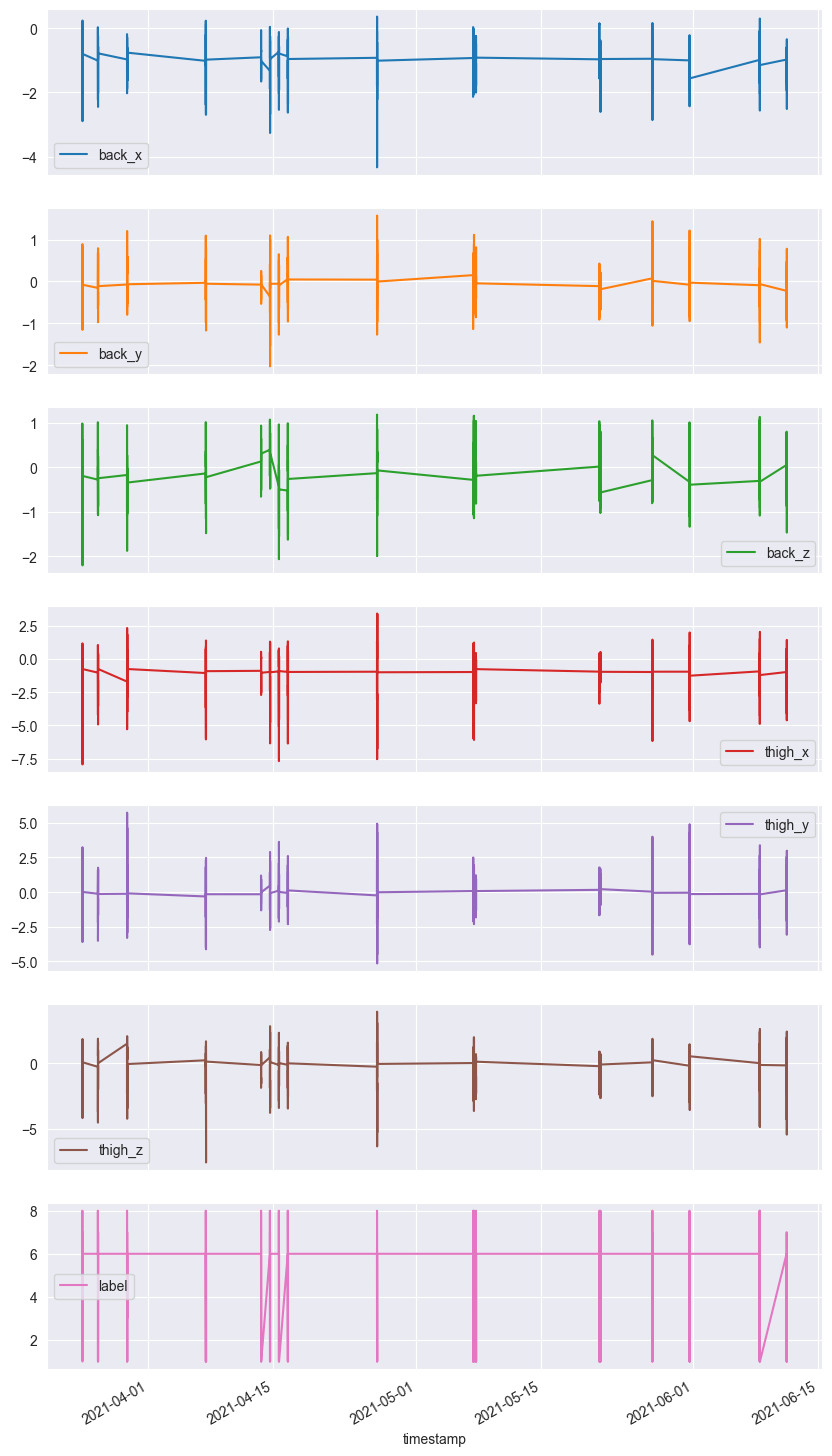

In [90]:
#build your line chart here
# IRO - Plotting the first 4 variables using Date as our X axis:
har70.plot('timestamp', ['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label'], subplots = True,figsize = [10,20])

In [76]:
from pandas.plotting import scatter_matrix
def add_regression(ax, x, y):
    slope, intercept = np.polyfit(x, y, 1)  # Linear regression
    x_vals = np.linspace(x.min(), x.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=1.5)  # Regression line

def plot_spearman(df):
    axes = pd.plotting.scatter_matrix(df, alpha=0.5,figsize = [10,10])
    corr = df.corr(method = 'spearman').to_numpy() #nonlinear
    
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.3f" %corr[i,j], (0.25, 0.1), xycoords='axes fraction', ha='center', va='center')
        add_regression(axes[i, j], df.iloc[:, j], df.iloc[:, i])
    
    plt.show()


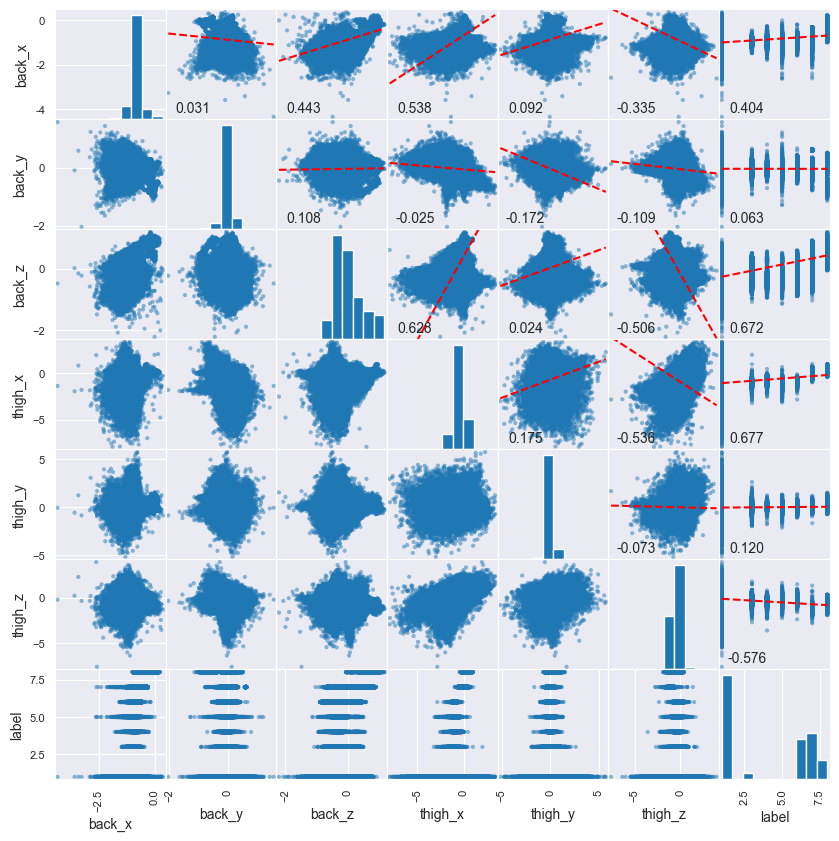

In [61]:
plot_spearman(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']])

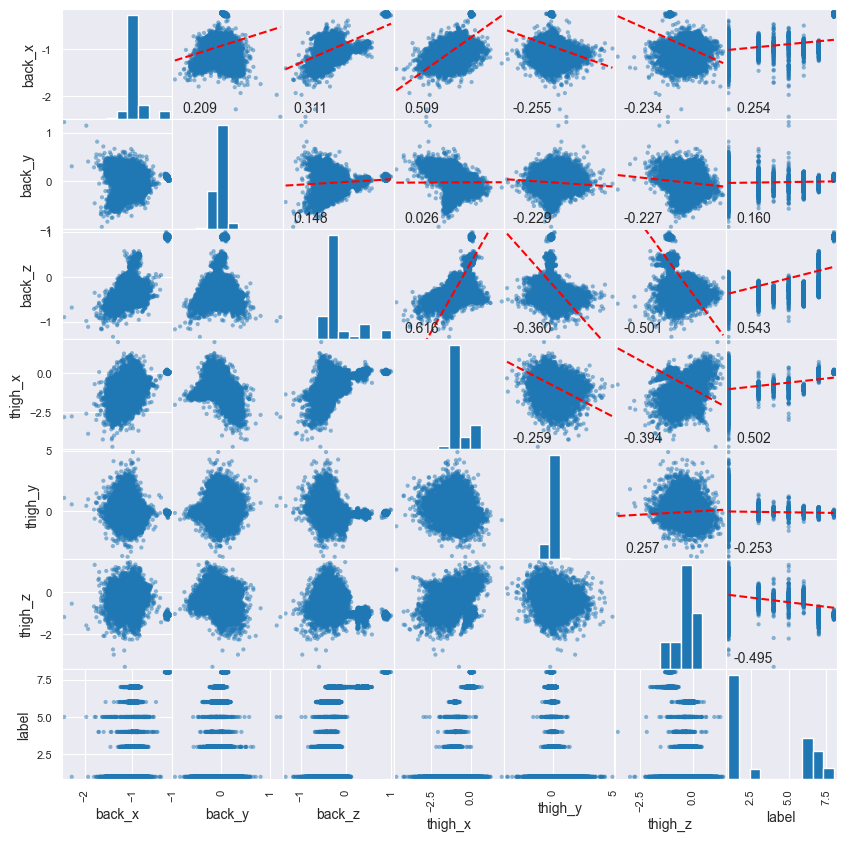

In [158]:
plot_spearman(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].loc[har70['filename']=='516.csv'])

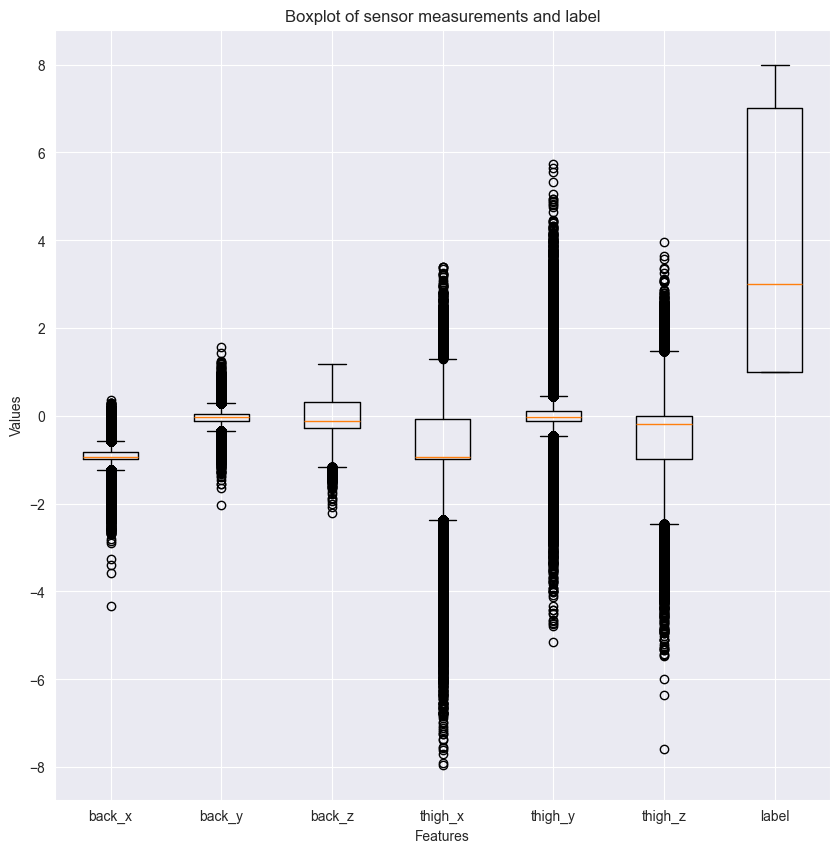

In [135]:
plt.figure(figsize=(10,10))
plt.boxplot(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].values, tick_labels=har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].columns)
plt.title('Boxplot of sensor measurements and label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

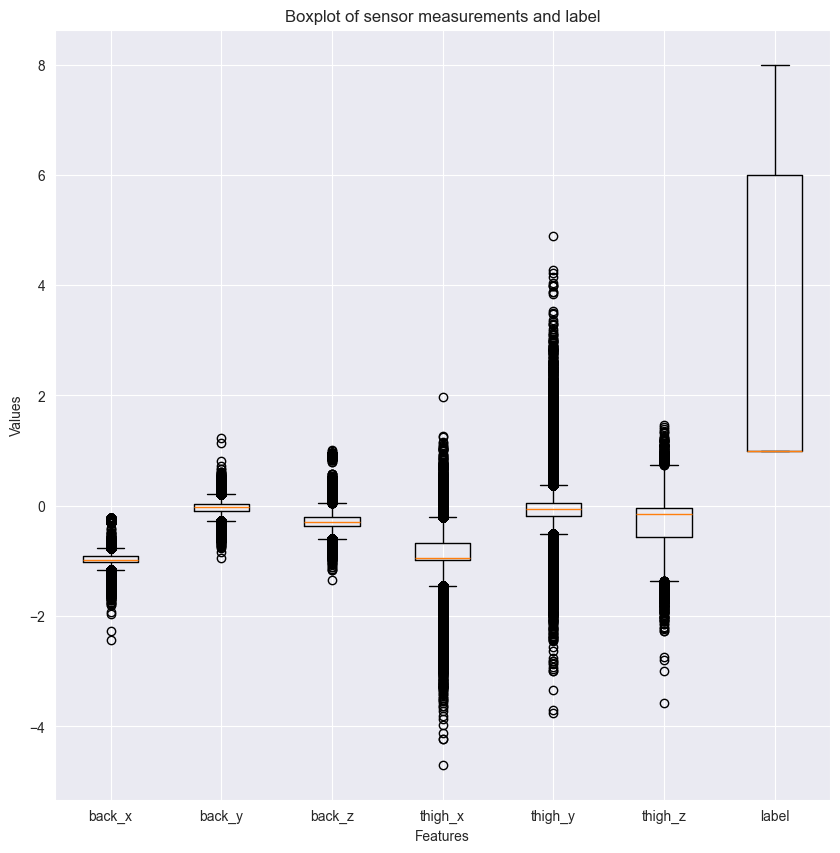

In [156]:
plt.figure(figsize=(10,10))
plt.boxplot(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].loc[har70['filename']=='516.csv'].values, tick_labels=har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].columns)
plt.title('Boxplot of sensor measurements and label')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

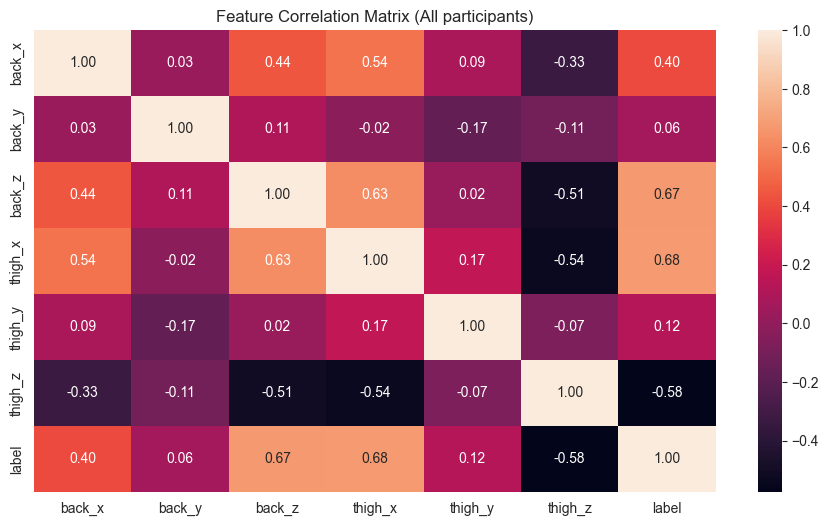

In [131]:
# Correlation matrix
plt.figure(figsize=(11,6))
sns.heatmap(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].corr(method = 'spearman'), annot=True, fmt='.2f')
plt.title('Feature Correlation Matrix (All participants)')
plt.show()

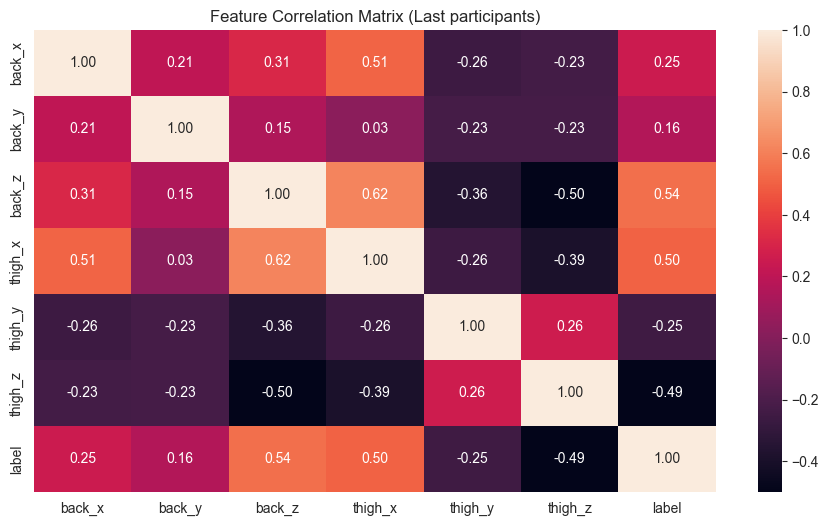

In [153]:
# Correlation matrix
plt.figure(figsize=(11,6))
sns.heatmap(har70[['back_x', 'back_y', 'back_z', 'thigh_x','thigh_y','thigh_z', 'label']].loc[har70['filename']=='516.csv'].corr(method = 'spearman'), annot=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Last participants)')
plt.show()